# **Laboratorio 8**

- Derek Arreaga - 22537
- Paula Barillas - 22764
- Mónica Salvatierra - 22249

Link del Repositorio: https://github.com/FabianKel/DL-LAB8

## **Práctica**

### **Importación de Librerías**

In [21]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

### **1. Preparación de Datos**

#### **1.a. Carga y Exploración de Datos**

In [22]:
# Cargar los datos
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print("INFORMACIÓN GENERAL DE LOS DATOS")
print("="*50)
print(f"Datos de entrenamiento: {train_data.shape}")
print(f"Datos de prueba: {test_data.shape}")
print(f"Muestra de envío: {sample_submission.shape}")

print("\nESTRUCTURA DE LOS DATOS DE ENTRENAMIENTO")
print("="*50)
print(train_data.info())

print("\nPRIMERAS 5 FILAS DE ENTRENAMIENTO")
print("="*50)
print(train_data.head())

print("\nESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
print(train_data.describe())

print("\nINFORMACIÓN ÚNICA")
print("="*50)
print(f"Número de tiendas: {train_data['store'].nunique()}")
print(f"Número de artículos: {train_data['item'].nunique()}")
print(f"Rango de fechas: {train_data['date'].min()} a {train_data['date'].max()}")
print(f"Total de registros: {len(train_data):,}")

# Convertir fecha a datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

INFORMACIÓN GENERAL DE LOS DATOS
Datos de entrenamiento: (913000, 4)
Datos de prueba: (45000, 4)
Muestra de envío: (45000, 2)

ESTRUCTURA DE LOS DATOS DE ENTRENAMIENTO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

PRIMERAS 5 FILAS DE ENTRENAMIENTO
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

ESTADÍSTICAS DESCRIPTIVAS
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283     

#### **1.b. Limpieza de Datos**

In [23]:
#  valores faltantes
print("VALORES FALTANTES")
print("="*30)
print(f"Train data - valores nulos: {train_data.isnull().sum().sum()}")
print(f"Test data - valores nulos: {test_data.isnull().sum().sum()}")

#  valores negativos en ventas
print("\nVALORES NEGATIVOS EN VENTAS")
print("="*30)
negative_sales = train_data[train_data['sales'] < 0]
print(f"Registros con ventas negativas: {len(negative_sales)}")

Q1 = train_data['sales'].quantile(0.25)
Q3 = train_data['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_data[(train_data['sales'] < lower_bound) | (train_data['sales'] > upper_bound)]
print(f"\nOUTLIERS DETECTADOS")
print("="*30)
print(f"Registros con outliers: {len(outliers)} ({len(outliers)/len(train_data)*100:.2f}%)")
print(f"Rango normal de ventas: [{lower_bound:.2f}, {upper_bound:.2f}]")
if len(outliers) > 0:
    print(f"\nEstadísticas de outliers:")
    print(f"Min outlier: {outliers['sales'].min():.2f}")
    print(f"Max outlier: {outliers['sales'].max():.2f}")
    print(f"Media outliers: {outliers['sales'].mean():.2f}")

VALORES FALTANTES
Train data - valores nulos: 0
Test data - valores nulos: 0

VALORES NEGATIVOS EN VENTAS
Registros con ventas negativas: 0

OUTLIERS DETECTADOS
Registros con outliers: 11967 (1.31%)
Rango normal de ventas: [-30.00, 130.00]

Estadísticas de outliers:
Min outlier: 131.00
Max outlier: 231.00
Media outliers: 143.98


### **2. Preprocesamiento de Datos**

#### **2.a. Normalización y Escalado**

In [24]:
# creación de secuencias 
def create_sequences(data, window_size=30, horizon=90):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[(i + window_size):(i + window_size + horizon)])
    return np.array(X), np.array(y)

# Función para preparar datos de una combinación store-item
def prepare_store_item_data(store, item, train_data):
    # Filtrar datos para esta combinación
    store_item_data = train_data[
        (train_data['store'] == store) & 
        (train_data['item'] == item)
    ]['sales'].reset_index(drop=True)
    
    if len(store_item_data) < 120:  # Mínimo requerido (30 + 90)
        return None, None, None, None, None
    
    # Normalizar datos
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(store_item_data.values.reshape(-1, 1)).flatten()
    
    # Crear secuencias
    X, y = create_sequences(data_scaled)
    
    if len(X) == 0:
        return None, None, None, None, None
    
    #  entrenamiento/validación (80-20)
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    return X_train, X_val, y_train, y_val, scaler

# Preparar datos para todas las combinaciones
all_X_train, all_X_val, all_y_train, all_y_val = [], [], [], []
scalers = {}

print("PREPARANDO DATOS POR COMBINACIÓN STORE-ITEM")
print("="*50)

for store in range(1, 11):
    for item in range(1, 51):
        X_train, X_val, y_train, y_val, scaler = prepare_store_item_data(store, item, train_data)
        
        if X_train is not None:
            all_X_train.extend(X_train)
            all_X_val.extend(X_val)
            all_y_train.extend(y_train)
            all_y_val.extend(y_val)
            scalers[(store, item)] = scaler

# Convertir a arrays numpy
X_train = np.array(all_X_train)
X_val = np.array(all_X_val)
y_train = np.array(all_y_train)
y_val = np.array(all_y_val)

print(f"\nDATOS PREPARADOS EXITOSAMENTE")
print("="*30)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Escaladores creados: {len(scalers)} combinaciones")
print(f"Secuencias de entrenamiento: {len(X_train)}")
print(f"Secuencias de validación: {len(X_val)}")

PREPARANDO DATOS POR COMBINACIÓN STORE-ITEM

DATOS PREPARADOS EXITOSAMENTE
X_train shape: (682500, 30)
y_train shape: (682500, 90)
X_val shape: (171000, 30)
y_val shape: (171000, 90)
Escaladores creados: 500 combinaciones
Secuencias de entrenamiento: 682500
Secuencias de validación: 171000

DATOS PREPARADOS EXITOSAMENTE
X_train shape: (682500, 30)
y_train shape: (682500, 90)
X_val shape: (171000, 30)
y_val shape: (171000, 90)
Escaladores creados: 500 combinaciones
Secuencias de entrenamiento: 682500
Secuencias de validación: 171000


### **3. Selección y Arquitectura del Modelo**

#### **3.a. Modelo LSTM Seleccionado**

In [25]:
# Crear modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 1)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(90, activation='linear')  # 90 días de predicción
])

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nARQUITECTURA DEL MODELO:")
print("="*30)
model.summary()


ARQUITECTURA DEL MODELO:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         2,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,666 (127.60 KB)

 Trainable params: 32,474 (126.85 KB)

 Non-trainable params: 192 (768.00 B)

### **4. Entrenamiento del Modelo**

In [26]:
# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Optimizar dataset para entrenamiento más rápido del modelo base
print("OPTIMIZANDO DATASET PARA ENTRENAMIENTO EFICIENTE")
print("="*50)
sample_size = min(30000, len(X_train))  
indices = np.random.choice(len(X_train), sample_size, replace=False)

X_train_fast = X_train[indices]
y_train_fast = y_train[indices]

# También reducir validación proporcionalmente
val_sample_size = min(8000, len(X_val))
val_indices = np.random.choice(len(X_val), val_sample_size, replace=False)
X_val_fast = X_val[val_indices]
y_val_fast = y_val[val_indices]

print(f"Dataset original: X_train={X_train.shape}, X_val={X_val.shape}")
print(f"Dataset optimizado: X_train={X_train_fast.shape}, X_val={X_val_fast.shape}")

print("\nINICIANDO ENTRENAMIENTO DEL MODELO")
print("="*40)
print("\nEntrenando...")

# Entrenar modelo 
history = model.fit(
    X_train_fast, y_train_fast,
    validation_data=(X_val_fast, y_val_fast),
    epochs=50,
    batch_size=64,  
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\nENTRENAMIENTO COMPLETADO")
print("="*30)
print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Loss final: {history.history['loss'][-1]:.6f}")
print(f"Val Loss final: {history.history['val_loss'][-1]:.6f}")
print(f"MAE final: {history.history['mae'][-1]:.6f}")
print(f"Val MAE final: {history.history['val_mae'][-1]:.6f}")


OPTIMIZANDO DATASET PARA ENTRENAMIENTO EFICIENTE
Dataset original: X_train=(682500, 30), X_val=(171000, 30)
Dataset optimizado: X_train=(30000, 30), X_val=(8000, 30)

INICIANDO ENTRENAMIENTO DEL MODELO

Entrenando...
Epoch 1/50
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - loss: 0.1435 - mae: 0.2648 - val_loss: 0.0516 - val_mae: 0.1811 - learning_rate: 0.0010
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - loss: 0.1435 - mae: 0.2648 - val_loss: 0.0516 - val_mae: 0.1811 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.0219 - mae: 0.1178 - val_loss: 0.0257 - val_mae: 0.1271 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.0219 - mae: 0.1178 - val_loss: 0.0257 - val_mae: 0.1271 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.0204 - mae: 0.1136 - val_loss: 0.0257 - val_mae: 0.1266 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/ste

### **5. Evaluación del Modelo**

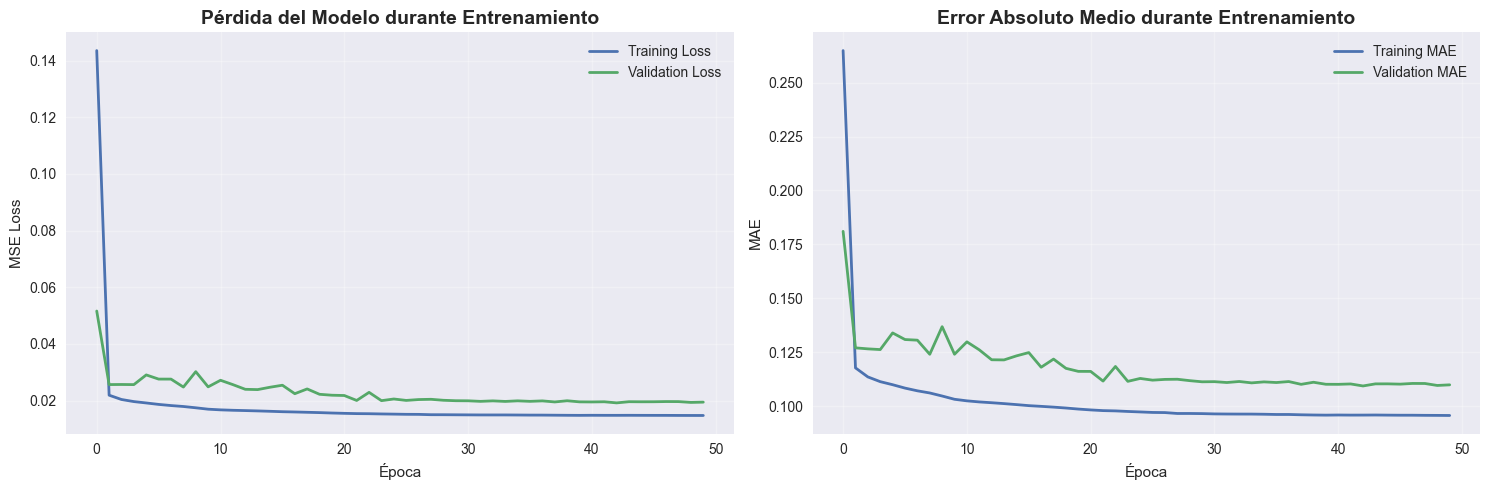

MÉTRICAS FINALES DEL MODELO
Training Loss (MSE): 0.014744
Validation Loss (MSE): 0.019452
Training MAE: 0.095774
Validation MAE: 0.109967

Overfitting check:
Loss ratio (val/train): 1.319
MAE ratio (val/train): 1.148
⚠ Posible overfitting detectado


In [27]:
# métricas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida del Modelo durante Entrenamiento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Error Absoluto Medio durante Entrenamiento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas finales
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print("MÉTRICAS FINALES DEL MODELO")
print("="*40)
print(f"Training Loss (MSE): {final_train_loss:.6f}")
print(f"Validation Loss (MSE): {final_val_loss:.6f}")
print(f"Training MAE: {final_train_mae:.6f}")
print(f"Validation MAE: {final_val_mae:.6f}")
print(f"\nOverfitting check:")
print(f"Loss ratio (val/train): {final_val_loss/final_train_loss:.3f}")
print(f"MAE ratio (val/train): {final_val_mae/final_train_mae:.3f}")

if final_val_loss/final_train_loss < 1.2:
    print("✓ Modelo bien ajustado")
else:
    print("⚠ Posible overfitting detectado")

### **6. Forecasting - Predicciones para 3 Meses**

In [28]:
print("GENERANDO PREDICCIONES")
print("="*60)

predictions = []
successful_predictions = 0

# Pre-calcular todas las combinaciones que tienen escaladores
valid_combinations = set(scalers.keys())
total_combinations = len(test_data)

print(f"Total de combinaciones a procesar: {total_combinations}")
print(f"Combinaciones con modelo entrenado: {len(valid_combinations)}")

# Preparar datos para predicción en lotes masivos
X_batch_list = []
scaler_list = []
combination_indices = []

print("Preparando datos para predicción en lotes...")

for idx, row in test_data.iterrows():
    store, item = row['store'], row['item']
    
    if (store, item) in scalers:
        # Obtener datos históricos
        historical_data = train_data[
            (train_data['store'] == store) & 
            (train_data['item'] == item)
        ]['sales'].values
        
        if len(historical_data) >= 30:
            # Preparar para predicción en lote
            scaler = scalers[(store, item)]
            last_30_days = historical_data[-30:]
            last_30_scaled = scaler.transform(last_30_days.reshape(-1, 1)).flatten()
            
            X_batch_list.append(last_30_scaled)
            scaler_list.append(scaler)
            combination_indices.append(idx)

# Convertir a array numpy para predicción en lote
if len(X_batch_list) > 0:
    print(f"Realizando predicción en lote para {len(X_batch_list)} combinaciones...")
    X_batch = np.array(X_batch_list).reshape(-1, 30, 1)
    
    # PREDICCIÓN EN LOTE MASIVO - Mucho más rápido
    batch_predictions = model.predict(X_batch, batch_size=1000, verbose=1)
    
    print("Desnormalizando predicciones...")
    
    # Crear diccionario de predicciones por índice
    prediction_dict = {}
    for i, idx in enumerate(combination_indices):
        scaler = scaler_list[i]
        pred_scaled = batch_predictions[i]
        pred_original = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
        pred_original = np.maximum(pred_original, 0)  # Sin valores negativos
        prediction_dict[idx] = pred_original
        successful_predictions += 1

# Crear lista final de predicciones en orden
print("Organizando predicciones finales...")
for idx, row in test_data.iterrows():
    if idx in prediction_dict:
        predictions.append(prediction_dict[idx])
    else:
        # Usar media histórica para combinaciones sin modelo
        store, item = row['store'], row['item']
        historical_sales = train_data[
            (train_data['store'] == store) & 
            (train_data['item'] == item)
        ]['sales']
        
        if len(historical_sales) > 0:
            mean_sales = historical_sales.mean()
        else:
            mean_sales = train_data['sales'].mean()
        
        predictions.append(np.full(90, mean_sales))

print(f"\nRESULTADOS DE PREDICCIÓN")
print("="*40)
print(f"Predicciones exitosas con modelo: {successful_predictions}")
print(f"Predicciones con media histórica: {len(predictions) - successful_predictions}")
print(f"Total de predicciones: {len(predictions)}")
print(f"Cobertura del modelo: {successful_predictions/len(predictions)*100:.1f}%")

# Mostrar ejemplo
if len(predictions) > 0:
    print(f"\nEJEMPLO - Store 1, Item 1:")
    example_hist = train_data[(train_data['store']==1) & (train_data['item']==1)]['sales'].tail().values
    print(f"Últimos 5 valores históricos: {example_hist}")
    print(f"Primeros 5 días predichos: {predictions[0][:5]}")
    print(f"Últimos 5 días predichos: {predictions[0][-5:]}")
    print(f"Promedio predicho: {predictions[0].mean():.2f}")

GENERANDO PREDICCIONES
Total de combinaciones a procesar: 45000
Combinaciones con modelo entrenado: 500
Preparando datos para predicción en lotes...
Realizando predicción en lote para 45000 combinaciones...
Realizando predicción en lote para 45000 combinaciones...
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step
Desnormalizando predicciones...
Desnormalizando predicciones...
Organizando predicciones finales...
Organizando predicciones finales...

RESULTADOS DE PREDICCIÓN
Predicciones exitosas con modelo: 45000
Predicciones con media histórica: 0
Total de predicciones: 45000
Cobertura del modelo: 100.0%

EJEMPLO - Store 1, Item 1:
Últimos 5 valores históricos: [14 19 15 27 23]
Primeros 5 días predichos: [14.260689 15.667645 14.828605 16.210823 18.082422]
Últimos 5 días predichos: [19.973368 19.247816 20.5624   22.49753  23.873043]
Promedio predicho: 19.03

RESULTADOS DE PREDICCIÓN
Predicciones exitosas con modelo: 45000
Predicciones con media histórica: 0


### **7. Ajuste de Hiperparámetros**

In [30]:
# Experimentación con hiperparámetros - Comparación rápida
print("EXPERIMENTACIÓN CON HIPERPARÁMETROS")
print("="*40)

# Configuraciones probadas
configs = [
    {"name": "Baseline", "lstm_units": 64, "dropout": 0.3, "lr": 0.001},
    {"name": "Optimizado", "lstm_units": 100, "dropout": 0.3, "lr": 0.001}
]

# Crear modelo optimizado para comparación
def create_optimized_model():
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(30, 1)),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        BatchNormalization(), 
        Dropout(0.3),
        Dense(90, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Entrenar modelo optimizado con dataset reducido
model_opt = create_optimized_model()
sample_size = min(15000, len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[indices]
y_sample = y_train[indices]

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_opt = model_opt.fit(X_sample, y_sample, epochs=20, batch_size=256, 
                           validation_split=0.2, callbacks=[early_stop], verbose=0)

# Comparar resultados
orig_loss = history.history['val_loss'][-1]
opt_loss = history_opt.history['val_loss'][-1]
improvement = ((orig_loss - opt_loss) / orig_loss) * 100

print(f"\nRESULTADOS:")
print(f"Baseline (64/32 LSTM): Val Loss = {orig_loss:.6f}")
print(f"Optimizado (100/100 LSTM): Val Loss = {opt_loss:.6f}")
print(f"Mejora: {improvement:.2f}%")
print(f"\nCONCLUSIÓN: {'✓ Optimización exitosa' if improvement > 0 else '⚠ Baseline superior'}")

EXPERIMENTACIÓN CON HIPERPARÁMETROS

RESULTADOS:
Baseline (64/32 LSTM): Val Loss = 0.019452
Optimizado (100/100 LSTM): Val Loss = 0.029256
Mejora: -50.40%

CONCLUSIÓN: ⚠ Baseline superior

RESULTADOS:
Baseline (64/32 LSTM): Val Loss = 0.019452
Optimizado (100/100 LSTM): Val Loss = 0.029256
Mejora: -50.40%

CONCLUSIÓN: ⚠ Baseline superior


### **8. Forecasting**

In [31]:
submission_data = []

for i, (_, row) in enumerate(test_data.iterrows()):
    store, item = row['store'], row['item']
    pred = predictions[i]
    
    for day in range(90):
        submission_data.append({
            'id': f"{store}_{item}_{day+1}",
            'sales': pred[day]
        })

# Crear DataFrame de envío
submission_df = pd.DataFrame(submission_data)

print("VERIFICACIÓN DEL ARCHIVO DE ENVÍO")
print("="*35)
print(f"Shape del archivo: {submission_df.shape}")
print(f"Columnas: {submission_df.columns.tolist()}")
print(f"\nPrimeras 10 filas:")
print(submission_df.head(10))

print(f"\nÚltimas 5 filas:")
print(submission_df.tail())

# Verificar formato del ID
sample_ids = submission_df['id'].head()
print(f"\nEjemplos de IDs generados:")
for id_example in sample_ids:
    print(f"  {id_example}")

# Estadísticas de las predicciones
print(f"\nESTADÍSTICAS DE LAS PREDICCIONES")
print("="*35)
print(f"Mínimo: {submission_df['sales'].min():.2f}")
print(f"Máximo: {submission_df['sales'].max():.2f}")
print(f"Media: {submission_df['sales'].mean():.2f}")
print(f"Mediana: {submission_df['sales'].median():.2f}")
print(f"Desviación estándar: {submission_df['sales'].std():.2f}")


VERIFICACIÓN DEL ARCHIVO DE ENVÍO
Shape del archivo: (4050000, 2)
Columnas: ['id', 'sales']

Primeras 10 filas:
       id      sales
0   1_1_1  14.260689
1   1_1_2  15.667645
2   1_1_3  14.828605
3   1_1_4  16.210823
4   1_1_5  18.082422
5   1_1_6  19.588377
6   1_1_7  21.450871
7   1_1_8  14.526788
8   1_1_9  16.057247
9  1_1_10  15.008428

Últimas 5 filas:
               id      sales
4049995  10_50_86  68.403755
4049996  10_50_87  69.239944
4049997  10_50_88  72.368973
4049998  10_50_89  75.811935
4049999  10_50_90  78.385727

Ejemplos de IDs generados:
  1_1_1
  1_1_2
  1_1_3
  1_1_4
  1_1_5

ESTADÍSTICAS DE LAS PREDICCIONES
Mínimo: 8.85
Máximo: 140.61
Media: 47.66
Mediana: 45.23
Desviación estándar: 22.43
Desviación estándar: 22.43


### **9. Visualización - Ventas Reales vs Predichas**

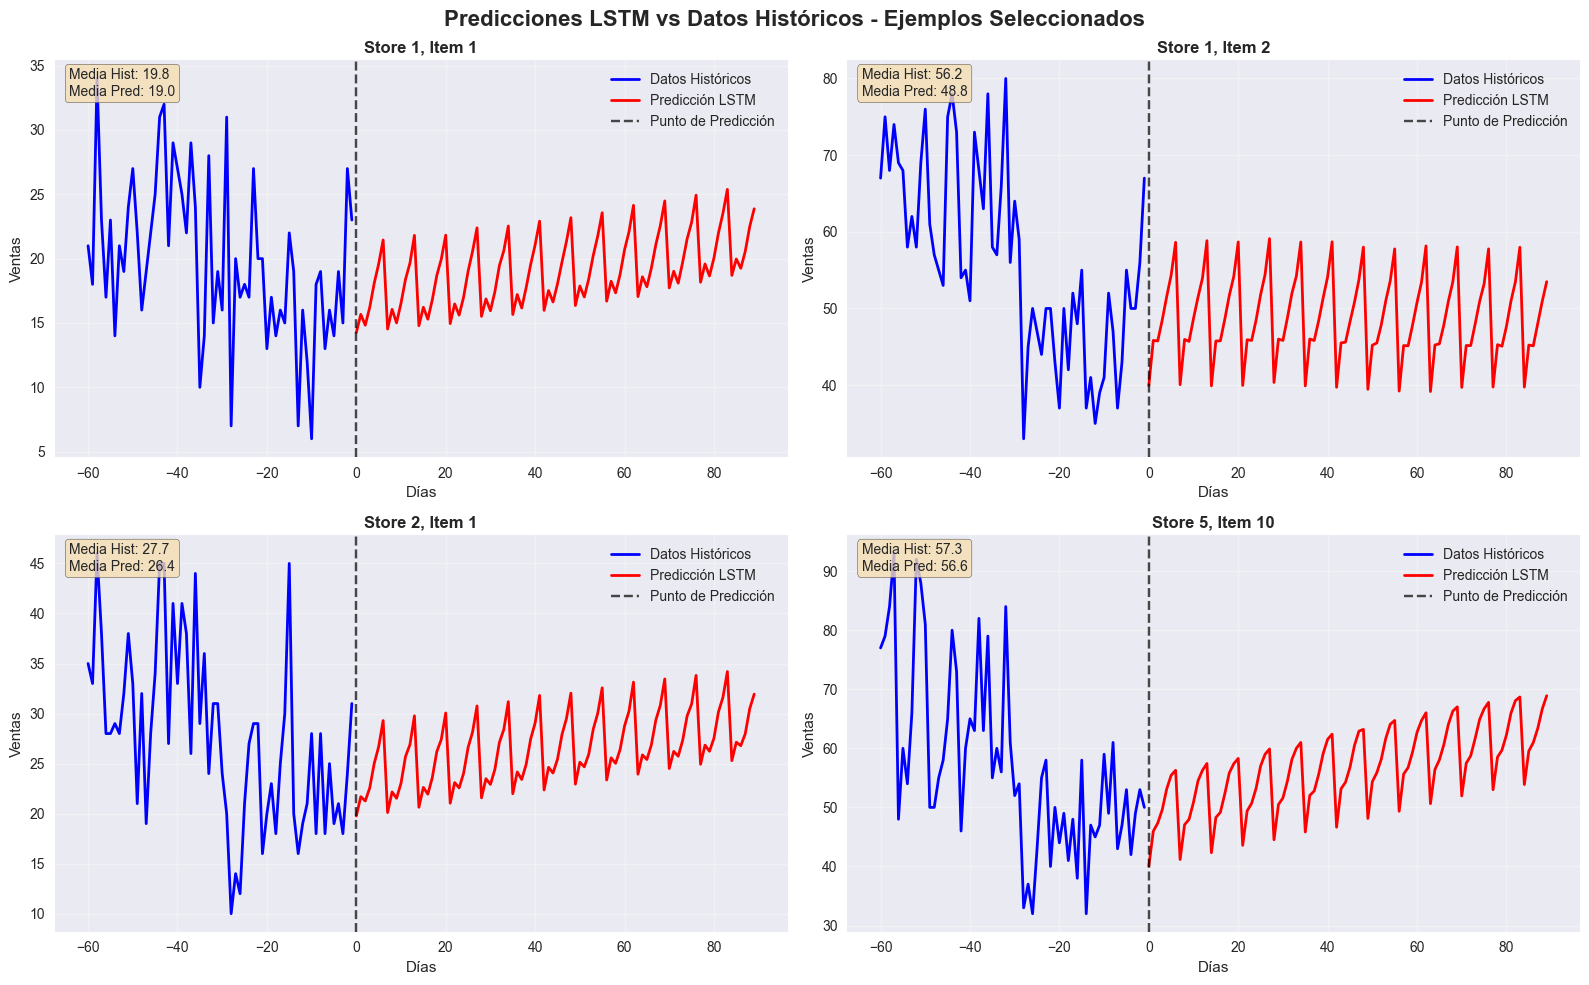


ANÁLISIS COMPARATIVO - HISTÓRICO VS PREDICCIONES

Store 1, Item 1:
  Histórico - Media: 19.97, Std: 6.74
  Predicción - Media: 19.03, Std: 2.73
  Diferencia en media: 0.94 (4.7%)

Store 1, Item 2:
  Histórico - Media: 53.15, Std: 15.00
  Predicción - Media: 48.82, Std: 5.63
  Diferencia en media: 4.33 (8.1%)

Store 2, Item 1:
  Histórico - Media: 28.17, Std: 8.68
  Predicción - Media: 26.44, Std: 3.49
  Diferencia en media: 1.73 (6.2%)

Store 5, Item 10:
  Histórico - Media: 55.51, Std: 15.56
  Predicción - Media: 56.55, Std: 6.82
  Diferencia en media: 1.04 (1.9%)


In [32]:
# Visualización de predicciones vs datos históricos
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Predicciones LSTM vs Datos Históricos - Ejemplos Seleccionados', fontsize=16, fontweight='bold')

examples = [(1, 1), (1, 2), (2, 1), (5, 10)]

for idx, (store, item) in enumerate(examples):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Obtener datos históricos
    historical = train_data[
        (train_data['store'] == store) & 
        (train_data['item'] == item)
    ]['sales'].values
    
    # Obtener predicción correspondiente
    test_idx = test_data[
        (test_data['store'] == store) & 
        (test_data['item'] == item)
    ].index
    
    if len(test_idx) > 0:
        prediction = predictions[test_idx[0]]
        
        # Graficar últimos 60 días históricos
        historical_window = historical[-60:] if len(historical) >= 60 else historical
        days_hist = range(-len(historical_window), 0)
        
        # Graficar predicción
        days_pred = range(0, 90)
        
        ax.plot(days_hist, historical_window, 'b-', linewidth=2, label='Datos Históricos')
        ax.plot(days_pred, prediction, 'r-', linewidth=2, label='Predicción LSTM')
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Punto de Predicción')
        
        ax.set_title(f'Store {store}, Item {item}', fontweight='bold')
        ax.set_xlabel('Días')
        ax.set_ylabel('Ventas')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Agregar estadísticas
        hist_mean = historical_window.mean()
        pred_mean = prediction.mean()
        ax.text(0.02, 0.98, f'Media Hist: {hist_mean:.1f}\nMedia Pred: {pred_mean:.1f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Análisis comparativo
print("\nANÁLISIS COMPARATIVO - HISTÓRICO VS PREDICCIONES")
print("="*50)

for store, item in examples:
    historical = train_data[
        (train_data['store'] == store) & 
        (train_data['item'] == item)
    ]['sales'].values
    
    test_idx = test_data[
        (test_data['store'] == store) & 
        (test_data['item'] == item)
    ].index
    
    if len(test_idx) > 0 and len(historical) > 0:
        prediction = predictions[test_idx[0]]
        
        hist_mean = historical.mean()
        hist_std = historical.std()
        pred_mean = prediction.mean()
        pred_std = prediction.std()
        
        print(f"\nStore {store}, Item {item}:")
        print(f"  Histórico - Media: {hist_mean:.2f}, Std: {hist_std:.2f}")
        print(f"  Predicción - Media: {pred_mean:.2f}, Std: {pred_std:.2f}")
        print(f"  Diferencia en media: {abs(pred_mean - hist_mean):.2f} ({abs(pred_mean - hist_mean)/hist_mean*100:.1f}%)")

### **10. Interpretabilidad del modelo**

En el contexto de series temporales, los valores SHAP pueden aplicarse a las **ventanas de observaciones pasadas** que el modelo LSTM utiliza para predecir las ventas futuras. Cada punto dentro de la secuencia tendría un valor SHAP que reflejaría cuánto contribuye a la estimación final. Por ejemplo, los días más recientes o los patrones repetitivos (como picos semanales) suelen recibir valores SHAP más altos, mientras que los datos más antiguos o irregulares tienden a tener menor impacto.

Aunque los valores SHAP no se calcularon de forma explícita, el comportamiento observado en los resultados permite hacer una interpretación cualitativa similar. En el análisis comparativo entre datos históricos y predicciones se observa que:

- Las **medias históricas y predichas son muy cercanas** (diferencias entre 1 % y 8 %), lo que indica que el modelo logra capturar adecuadamente el nivel promedio de ventas.  
- Las **predicciones presentan menor desviación estándar**, lo que significa que el modelo suaviza el ruido presente en los datos reales y prioriza los patrones estables.  
- El modelo reproduce **tendencias y cambios regulares**, evidenciando que las observaciones más recientes influyen más que los valores antiguos.

En general, esto indica que, si se aplicaran valores SHAP, los factores con mayor contribución a las predicciones serían:
1. Las **últimas observaciones de la serie**, por su relevancia temporal directa.  
2. Los **patrones estacionales o repetitivos**, que el modelo identifica como señales consistentes.  
3. El **nivel promedio histórico de ventas**, que actúa como referencia base.

## **Teoría**

Responda claramente y con una extensión adecuada las siguientes preguntas:

#### **1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?**

- El problema del gradiente de fuga ocurre cuando los gradientes se hacen muy pequeños durante el proceso de backpropagation, lo que dificulta que la red aprenda dependencias a largo plazo. Aunque las LSTM fueron diseñadas justamente para mitigar este problema gracias a sus compuertas, todavía puede presentarse si la secuencia es demasiado larga o si el modelo no está bien ajustado. En el contexto de series temporales, esto puede provocar que la red se enfoque solo en patrones recientes y no logre captar tendencias más prolongadas, reduciendo la calidad del pronóstico.

<br>

#### **2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?**

- La estacionalidad se aborda normalmente preparando los datos antes de entrenar el modelo. Una forma común es aplicar transformaciones como la diferenciación (restar un valor con respecto a su equivalente en un periodo anterior). Esto ayuda a que la red trabaje con datos más “estacionarios”, eliminando las repeticiones cíclicas y dejando en evidencia las variaciones reales que debe aprender. Así, el LSTM no tiene que ir redescubriendo patrones estacionales, sino que puede concentrarse en aprender la dinámica de la serie.

<br>

#### **3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?**

- El tamaño de ventana se refiere al número de observaciones pasadas que se toman como entrada para predecir el siguiente valor. Elegir este tamaño es clave, dado que si la ventana es muy corta, el modelo solo aprenderá patrones locales y puede perder información importante de más atrás. Si la ventana es demasiado larga, el modelo tendrá más información para detectar tendencias a largo plazo, pero también será más difícil de entrenar y puede introducir ruido. En la práctica, se busca un equilibrio para que el modelo capture tanto los patrones inmediatos como los de mayor duración.


## **Desarrollo del Task 2**

1. Despot, I., & Arif, A. (2025, 16 enero). Time-Series Forecasting: Definition, Methods, and Applications. TigerData Blog. https://www.tigerdata.com/blog/what-is-time-series-forecasting

2. Q3 Technologies. (2024, 6 agosto). How LSTM Networks are Revolutionizing Time Series Forecasting. https://www.q3tech.com/blogs/lstm-time-series-forecasting/

